# Preparation

In [1]:
import matplotlib.animation as animation
# % matplotlib notebook
# imports
import matplotlib.pyplot as plt
import numpy as np
from data_fusion.utils.data_parsing import nusc

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.297 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.
Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.353 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


# 1

### 1 C

scene
> A car's journey in (roughly/max) 20 seconds - includes id, additional info, date and time, duration and location 


sample 
> A sample is a scene at a given moment/timestamp that includes the information of radar type and describes the scine by categorazing instances of an object (pedestrian, tree ...)


sample annotation 
> Gives information about an instance of an object (e.g. pedestrian) - coordinates, number of points, category ...


instance
> Object instances that we're tracking (truck, pedestrian, tree ...)


keyframe
> Which coordinate systems are used and which data are given in which coordinate system? 
> There are two coordinate systems. One is car-centric so all the different sensors have the coordinates of the translation and rotation from the vehicle centre point. Listed are also the x and y way velocities, as well as dynamic proprety of a cluser etc. The other coordinate system is the 'world' one where the vehicle is placed on the map. This system also has a translation and a rotation of the centre-point of the vahicle from the centre of the map.

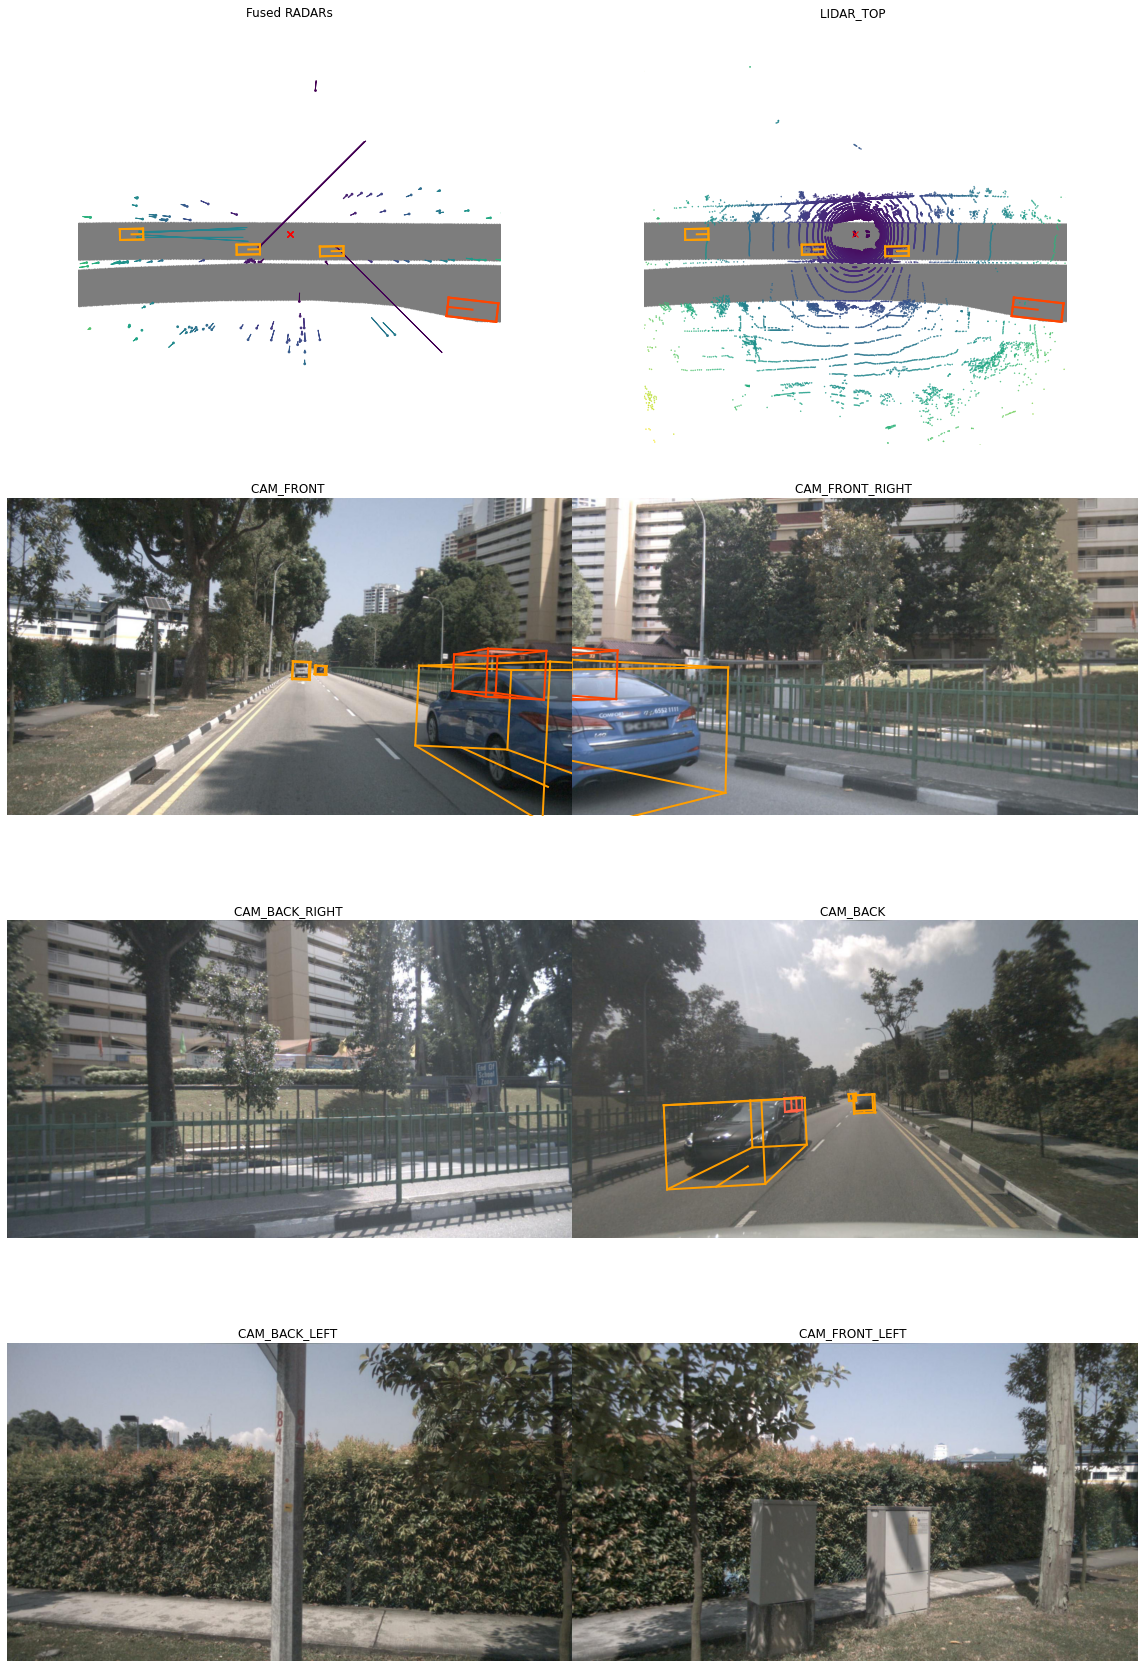

In [2]:
nusc.render_sample(nusc.scene[5]['last_sample_token'])


- Differentiate between (non)-static instances
- Catching relevant instances (humans with unlikely traffic interaction)
- Catching temporary obstacles/instances (construction stuff) and re-evaluate the relevant parts of the streets

# 2 B + D without Doppler velocities

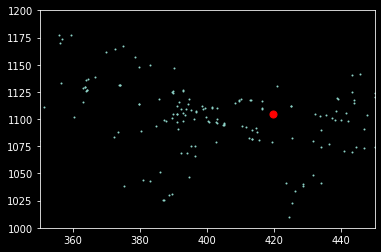

In [3]:
from IPython.core.display import HTML
from sympy import Inverse

from data_fusion.definitions import X_LIM_MAX, X_LIM_MIN, Y_LIM_MAX, Y_LIM_MIN, VEHICLE_LENS, SCENE_LENGTH
from data_fusion.utils.data import base_data
from data_fusion.utils.data_parsing import result
from data_fusion.utils.helpers import get_point_coords_from_v_comp, reduce_measurement, NoRowException
from data_fusion.kalman.basic_kalman import update_predictions_basic_kalman

plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)


def update(i):
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    px, py = row[0], row[1]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)

    plt.scatter(px, py, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')

    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=SCENE_LENGTH, interval=100)
# plt.show()

HTML(ani.to_html5_video())

# 2 B + D Plotting Doppler velocities

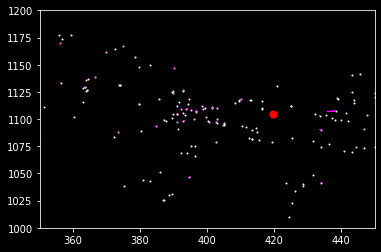

In [4]:
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)


def update(i):
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    px, py = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    new_p = get_point_coords_from_v_comp(vx, vy, px, py, radar_ego_x, radar_ego_y)

    distance_x = new_p[2]
    distance_y = new_p[3]

    plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)

    plt.scatter(px, py, s=1, color='white')
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')

    for i in range(len(px)):
        plt.arrow(px[i], py[i], distance_x[i], distance_y[i], color="magenta")

    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=SCENE_LENGTH, interval=100)
#plt.show()

HTML(ani.to_html5_video())

# 2 C + D Plotting bounding boxes

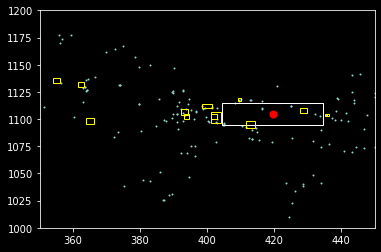

In [5]:
from data_fusion.utils.data_parsing import scene_anns
from data_fusion.entities.Vehicle import get_vehicles_from_sample
from matplotlib.patches import Rectangle

plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

last = None


def update(frame):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    px, py = row[0], row[1]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    vehicles = get_vehicles_from_sample(scene_anns[frame])
    veh_coords = [veh.get_trans() for veh in vehicles]
    veh_coords_x = [veh_x[0] for veh_x in veh_coords]
    veh_coords_y = [veh_y[1] for veh_y in veh_coords]

    plt.scatter(px, py, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')

    plt.gca().add_patch(Rectangle((radar_ego_x - 15, radar_ego_y - 10), 30, 20, color="white", fill=False))

    for i in range(len(veh_coords_y)):
        color = 'yellow'
        plt.gca().add_patch(
            Rectangle((veh_coords_x[i], veh_coords_y[i]), vehicles[i].w, vehicles[i].h, color=color, fill=False))

    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=SCENE_LENGTH, interval=100)
# plt.show()
HTML(ani.to_html5_video())

# 3 A

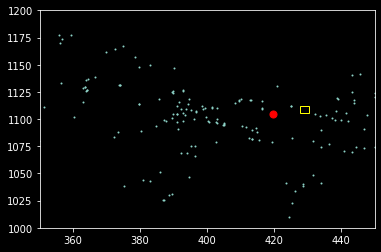

In [6]:
from data_fusion.entities.annotations import FOCUS_VEHICLES

plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)


def update(i):
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    px, py = row[0], row[1]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    vehicles = FOCUS_VEHICLES
    veh_coords = [veh.get_trans() for veh in vehicles]
    veh_coords_x = [veh_x[0] for veh_x in veh_coords]
    veh_coords_y = [veh_x[1] for veh_x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()

    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

    plt.scatter(px, py, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    plt.gca().add_patch(
        Rectangle((veh_coords_x[i], veh_coords_y[i]), vehicles[i].w * VEHICLE_LENS, vehicles[i].h * VEHICLE_LENS,
                  color='yellow',
                  fill=False))
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=SCENE_LENGTH, interval=100)
# plt.show()
HTML(ani.to_html5_video())

# 3 B Filter the Pointclouds

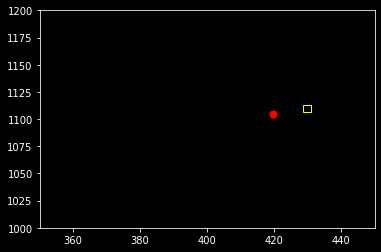

In [7]:

# all radar points in box
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

count = 0
last = None


def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    px, py = row[0], row[1]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    vehicles = FOCUS_VEHICLES
    veh_coords = [v.get_trans() for v in vehicles]
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()

    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

    current_x_min = veh_coords_x[count]
    current_y_min = veh_coords_y[count]
    width = vehicles[count].w * VEHICLE_LENS
    height = vehicles[count].h * VEHICLE_LENS
    plt.gca().add_patch(Rectangle((current_x_min, current_y_min), width, height, color='yellow', fill=False))
    count += 1
    coords, new_x, new_y = [], [], []
    for p in list(zip(px, py)):
        is_in_x = current_x_min <= p[0] <= current_x_min + width
        is_in_y = current_y_min <= p[1] <= current_y_min + height
        if is_in_x and is_in_y:
            coords.append(p)

    new_x = [t[0] for t in coords]
    new_y = [t[1] for t in coords]
    plt.scatter(new_x, new_y, s=1)
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=SCENE_LENGTH, interval=100)
# plt.show()
HTML(ani.to_html5_video())

# 3 C Average points

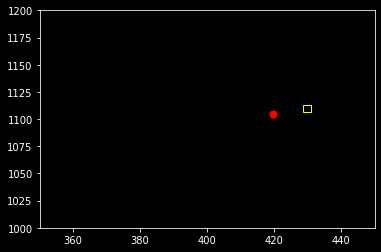

In [8]:
plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

result_iterator = iter(result)

count = 0
last = None


def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    px, py = row[0], row[1]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    vehicles = FOCUS_VEHICLES
    veh_coords = [v.get_trans() for v in vehicles]
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()

    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

    current_x_min = veh_coords_x[count]
    current_y_min = veh_coords_y[count]
    width = vehicles[count].w * VEHICLE_LENS
    height = vehicles[count].h * VEHICLE_LENS

    plt.gca().add_patch(Rectangle((current_x_min, current_y_min), width, height, color='yellow', fill=False))

    count += 1
    coords, new_x, new_y = [], [], []
    for p in list(zip(px, py)):
        is_in_x = current_x_min <= p[0] <= current_x_min + width
        is_in_y = current_y_min <= p[1] <= current_y_min + height
        if is_in_x and is_in_y:
            coords.append(p)

    new_x = ([t[0] for t in coords])
    new_y = ([t[1] for t in coords])
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    if new_x == [] or new_y == []:
        plt.plot()
        return
    new_x = sum(new_x) / len(new_x)
    new_y = sum(new_y) / len(new_y)
    plt.scatter(new_x, new_y, s=1)
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=SCENE_LENGTH, interval=100)
# plt.show()
HTML(ani.to_html5_video())

# 3 D - Add the Ground Truth to the graph

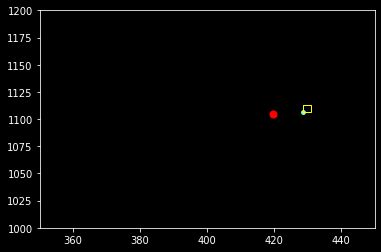

In [9]:
# average points
from statistics import mean

plt.style.use('dark_background')

ys = list()
xs = list()
ego_x = list()
ego_y = list()

avg_x = []
avg_y = []

result_iterator = iter(result)

count = 0
last = None

# TODO(Valerius): refactor
coords_velocity = []


def update(i):
    global count
    try:
        row = next(result_iterator)
    except StopIteration:
        return
    x, y = row[0], row[1]
    vx, vy = row[3], row[4]
    radar_ego_x = row[6][0]
    radar_ego_y = row[6][1]

    plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    vehicles = FOCUS_VEHICLES
    veh_coords = [v.get_trans() for v in vehicles]
    veh_coords_x = [x[0] for x in veh_coords]
    veh_coords_y = [x[1] for x in veh_coords]
    veh_coords_x.reverse()
    veh_coords_y.reverse()

    veh_coords_x = np.asarray(veh_coords_x)
    veh_coords_y = np.asarray(veh_coords_y)

    current_x_min = veh_coords_x[count]
    current_y_min = veh_coords_y[count]
    width = vehicles[count].w * VEHICLE_LENS
    height = vehicles[count].h * VEHICLE_LENS
    plt.gca().add_patch(Rectangle((current_x_min, current_y_min), width, height, color='yellow', fill=False))
    coords, new_x, new_y = [], [], []
    for i, p in enumerate(list(zip(x, y))):
        is_in_x = current_x_min <= p[0] <= current_x_min + width
        is_in_y = current_y_min <= p[1] <= current_y_min + height
        if is_in_x and is_in_y:
            coords.append(p)
            current_data = {
                'x': x[i],
                'y': y[i],
                'vx': vx[i],
                'vy': vy[i],
                'row': count,
                'gt_x': veh_coords_x[count],
                'gt_y': veh_coords_y[count]
            }
            coords_velocity.append(current_data)

    new_x = ([t[0] for t in coords])
    new_y = ([t[1] for t in coords])
    plt.scatter(radar_ego_x, radar_ego_y, s=50, color='red')
    plt.scatter(veh_coords_x[count], veh_coords_y[count], s=15, color='aquamarine')
    
    count += 1
    if not new_x or not new_y:
        plt.plot()
        return
    new_x = sum(new_x) / len(new_x)
    new_y = sum(new_y) / len(new_y)
    avg_x.append(new_x)
    avg_y.append(new_y)
    plt.scatter(new_x, new_y, s=15, color='#00ff00')
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=37, interval=100)
# plt.show()
HTML(ani.to_html5_video())

# Excersise 4

## Initialise everything

In [10]:
#initial state -> x = [x, y, delta_x, delta_y]
#coords_velocity needed

x1 = base_data[0]['x']
y1 = base_data[0]['y']
x2 = base_data[1]['x']
y2 = base_data[1]['y']

x_init = [[x1], [y1], [x2 - x1], [y2 - y1]]

# init the "pick"-parameters

# initialise Cxx aka error covariance
Cxx_init = np.eye(4)

# initialise sigma
sigma = 1

# initialise Cvv aka R
R = np.eye(2)

# define / initialise Q aka process noise covariance aka Cww
q = np.array([[.125], [.125], [.5], [.5]])
Q = q @ ((sigma ** 2) * q.T)

# define / initialise F aka A aka T aka time update matrix
A = np.eye(4)
A[0][2] = 0.5
A[1][3] = 0.5

# define / initialise H aka the measurement matrix
H = np.eye(2, 4)

## 4.a) TIME UPDATE FORMULAS :

In [11]:
# x_k+1 | k
def predict_state_x(x):
    x_predict = A @ x
    return x_predict


# TODO: sicher stellen dass wir alle scenes haben !!
#     -> falls nicht calc rauslassen, prediction kann bleiben

# test
x_predict1 = predict_state_x(x_init)


#x_predict1


# Cxx_k+1 | k
def predict_covariance_Cxx(current_Cxx):
    Cxx_predict = A @ current_Cxx @ A.T + Q
    return Cxx_predict


# test
Cxx_predict1 = predict_covariance_Cxx(Cxx_init)
#Cxx_predict1

In [12]:
# calculate yk aka the measurements
def measurement_model_yk(x_current):
    y_k = H @ x_current
    return y_k


# test
yk1 = measurement_model_yk(x_init)
#yk1, x_init

In [13]:
# calculate Kalman gain
def calc_kalman_gain(Cxx_predict):
    K_gain = Cxx_predict @ H.T @ np.linalg.inv(H @ Cxx_predict @ H.T + R)
    return K_gain


# test
K_gain1 = calc_kalman_gain(Cxx_predict1)
#K_gain1

## 4.b) MEASUREMENT UPDATES

In [14]:
# x_k+1
def measurement_update_x(x_predicted, y_k, K_gain):
    x_measurement = x_predicted + K_gain @ (y_k - H @ x_predicted)
    return x_measurement


# test
meas_x = measurement_update_x(x_predict1, yk1, K_gain1)
meas_x


# Cxx_k+1
def measurement_covariance_Cxx(Cxx_predicted, K_gain):
    Cxx_measurement = Cxx_predicted - K_gain @ H @ Cxx_predicted
    return Cxx_measurement


# test
meas_Cxx = measurement_covariance_Cxx(Cxx_predict1, K_gain1)
#meas_Cxx

Function flow:

1. `x_init` -> `predict_state_x(x_init)`
2. init_Cxx -> predict_covariance_Cxx(init_Cxx)
3. K_gain_init -> calc_kalman_gain(2.)
4. x_init -> measurement_model_yk(x_init)

mesurement_upate_x(1., 4., 3.)
measurement_covariance_Cxx(2., 3.)

<Figure size 432x288 with 0 Axes>

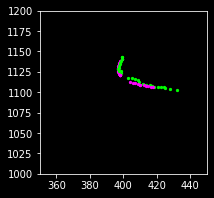

In [15]:
# plot prediction vs. actual state aka ground truth
# %matplotlib inline
plt.clf()
plt.figure(figsize=(3, 3))
plt.style.use('dark_background')
from data_fusion.utils.data import base_data

x = list()
y = list()

result_iterator = iter(base_data)

predictions = update_predictions_basic_kalman()
basic_kalman_coordinates = []

last_row = 0

def update(frame):
    global last_row
    row = reduce_measurement(frame, base_data)
    if row:
        last_row = frame
    else:
        row = reduce_measurement(last_row, base_data)

    current_prediction = predictions[frame]

    basic_kalman_coordinates.append(current_prediction)
    px = current_prediction[0]
    py = current_prediction[1]

    gt_x = row['gt_x']
    gt_y = row['gt_y']

#     plt.cla()
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    plt.scatter(gt_x, gt_y, s=5, color='magenta')  # GTs
    plt.scatter(px, py, s=5, color='#00ff00')  # predictions
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=27, interval=100)
HTML(ani.to_html5_video())
# predictions

# Exercise 6
Given an `index`, return the state $x = [x_1~ x_2~ v~ \alpha]^T$.

# 6 A

# 6 B

<Figure size 432x288 with 0 Axes>

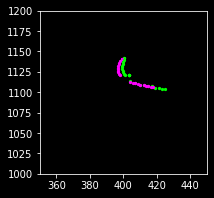

In [16]:
from data_fusion.kalman.extended_kalman import *

# plot prediction vs. actual state aka ground truth
# %matplotlib inline
plt.clf()
plt.figure(figsize=(3, 3))
plt.style.use('dark_background')

result_iterator = iter(base_data)


def update_predictions():
    c_meas = cxx_init
    x_meas = ekf_state(0)

    collector = []

    for i in range(27):
        state = ekf_state(i)  # get x, y
        x_pred = ekf_prediction_x(x_meas)  # calc a(^x^)
        c_pred = ekf_prediction_c(c_meas)  # calc c with A_x and c init
        
        if len(state) == 0:
            pred = np.array([x_pred[0][0], x_pred[1][0]])
            collector.append(pred)
            continue
            
        [rr, qq] = r_fn(i)  # calc r1 and r2 (difference between object and ego_pose)
        rr = rr[0]
        qq = qq[0]

        gt_x = base_data[i]['gt_x']
        gt_y = base_data[i]['gt_y']
        gt_v = base_data[i]['v']
        gt_alpha = base_data[i]['alpha']
        z = np.array([[gt_x], [gt_y], [gt_v], [gt_alpha]])

        y_k = measurement_y_k(z, rr, qq)  # calculate h(x)
        y_k_mean = measurement_y_k(x_pred, rr, qq)  # calc h(^x^)
        H_jac = H_x(rr, qq, v_val, alpha_val)
        kalman = K(c_pred, H_jac)
        x_meas = ekf_measurement_x(x_pred, y_k, y_k_mean, kalman)
        c_meas = ekf_measurement_c(c_pred, kalman, H_jac)
        pred = np.array([x_meas[0], x_meas[1]])
        collector.append(pred)

    return np.array(collector, dtype=float)


predictions = update_predictions()
extended_kalman_coordinates = []
ground_truth_coordinates = []

def update(frame):
    row = reduce_measurement(frame, base_data)
    
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    
    current_prediction = predictions[frame]
    extended_kalman_coordinates.append(current_prediction)
    px = current_prediction[0]
    py = current_prediction[1]
    plt.scatter(px, py, s=5, color='#00ff00')  # predictions

    if not row:
        plt.plot()
        return
    gt_x = row['gt_x']
    gt_y = row['gt_y']

    ground_truth_coordinates.append(np.array([gt_x, gt_y], dtype=float))
    plt.scatter(gt_x, gt_y, s=5, color='magenta')  # GTs
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=27, interval=100)
HTML(ani.to_html5_video())
# predictions

# Exercise 8 A

<Figure size 432x288 with 0 Axes>

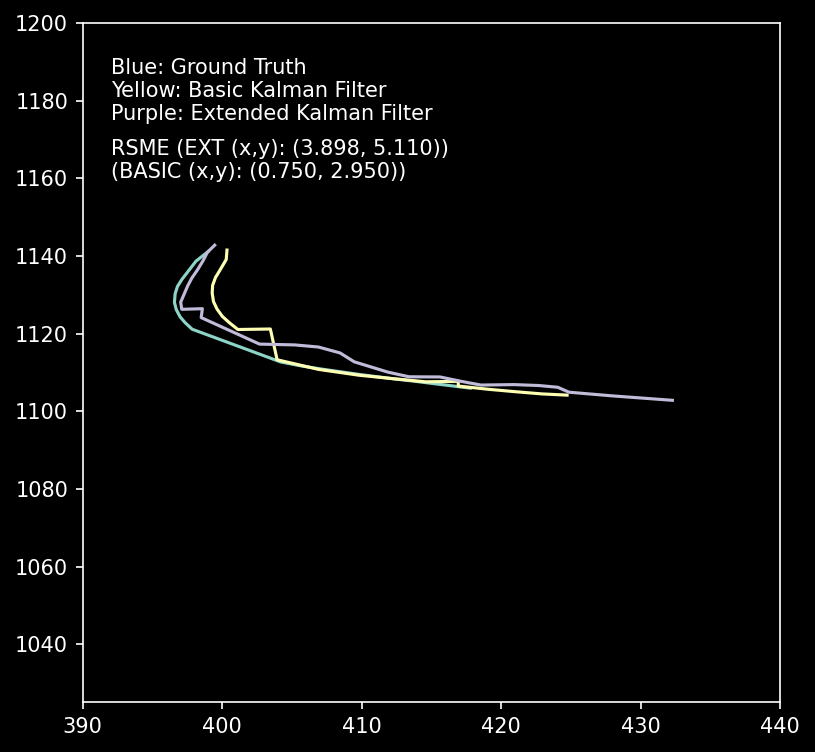

In [17]:
# basic_kalman_coordinates
# extended_kalman_coordinates
# ground_truth_coordinates

def rsme_axis(prediction, ground_truth):
    prediction = prediction[:22]
    diff = np.array(prediction) - np.array(ground_truth)
    sq_diff = np.power(diff, 2)
    s = sum(sq_diff)
    return np.sqrt(s / 22.0)


bk_x = rsme_axis([g[0] for g in basic_kalman_coordinates], [g[0] for g in ground_truth_coordinates])
bk_y = rsme_axis([g[1] for g in basic_kalman_coordinates], [g[1] for g in ground_truth_coordinates])

ext_x = rsme_axis([g[0] for g in extended_kalman_coordinates], [g[0] for g in ground_truth_coordinates])
ext_y = rsme_axis([g[1] for g in extended_kalman_coordinates], [g[1] for g in ground_truth_coordinates])

plt.clf()
plt.figure(figsize=(6, 6), dpi=150)
plt.style.use('dark_background')

plt.ylim(1025, Y_LIM_MAX)
plt.xlim(390, 440)
plt.plot([g[0] for g in ground_truth_coordinates], [g[1] for g in ground_truth_coordinates])
plt.plot([g[0] for g in extended_kalman_coordinates], [g[1] for g in extended_kalman_coordinates])
plt.plot([g[0] for g in basic_kalman_coordinates], [g[1] for g in basic_kalman_coordinates])
# plt.grid(True)
plt.text(392, 1175, """Blue: Ground Truth
Yellow: Basic Kalman Filter
Purple: Extended Kalman Filter""")

esx = '{:0.3f}'.format(float(ext_x))
esy = '{:0.3f}'.format(float(ext_y))
bsx = '{:0.3f}'.format(float(bk_x))
bsy = '{:0.3f}'.format(float(bk_y))

plt.text(392, 1160, f'RSME (EXT (x,y): ({esx}, {esy}))\n(BASIC (x,y): ({bsx}, {bsy}))')
plt.show()


# Exercise 7

## 7 B

In [30]:
from data_fusion.kalman.uncented_kalman import *
from data_fusion.kalman.uncented_kalman import update_predictions as up
from data_fusion.kalman.extended_kalman import *

# plot prediction vs. actual state aka ground truth
# %matplotlib inline
plt.clf()
plt.figure(figsize=(3, 3))
plt.style.use('dark_background')

result_iterator = iter(base_data)




predictions = up()


def update(frame):
    row = reduce_measurement(frame, base_data)
    
    plt.ylim(Y_LIM_MIN, Y_LIM_MAX)
    plt.xlim(X_LIM_MIN, X_LIM_MAX)
    
    current_prediction = predictions[frame]

    px = current_prediction[0]
    py = current_prediction[1]
    plt.scatter(px, py, s=5, color='#00ff00')  # predictions

    if not row:
        plt.plot()
        return
    gt_x = row['gt_x']
    gt_y = row['gt_y']


    plt.scatter(gt_x, gt_y, s=5, color='magenta')  # GTs
    plt.plot()


ani = animation.FuncAnimation(plt.gcf(), update, frames=27, interval=100)
HTML(ani.to_html5_video())
# predictions

LinAlgError: Matrix is not positive definite

<Figure size 432x288 with 0 Axes>

<Figure size 216x216 with 0 Axes>